In [1]:
import os
import ast
import collections

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
from scipy.spatial import distance
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score, 
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    auc, 
    balanced_accuracy_score
)


import torch
from torch_geometric import seed_everything
from torch_geometric.data import HeteroData, Data
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.utils import to_networkx, homophily, subgraph, remove_isolated_nodes
import torch_geometric.transforms as T
import torch.nn.functional as F




In [10]:
# Config

DATA_DIR = '/mnt/graphdata/lpa/'
FEATURES_DIR = '/mnt/graphdata/features/community'
RANDOM_SEED = 42

IS_MULTI_LABEL = True
FEATURES_HIERARCHICAL_LEVEL = 2  # 0-4
METADATA_TYPE = 'tissue' # 'tissue' or 'taxon'
EDGE_WEIGHT_THRESHOLD = 0

ACTIVATION_THRESHOLD = 0.5
EVAL_MASK_RATIO = 0.99
MASK_TYPE = 'random' # 'random', 'random_ones', 'high_homophily', 'low_homophily'
FP_ITERATIONS = 100
EXCLUDE_ISOLATED_NODES = True
MASK_VALUE = float('nan') # 0, float('nan') 

seed_everything(42)

In [3]:
class IdentityEncoder(object):
    # The 'IdentityEncoder' takes the raw column values and converts them to
    # PyTorch tensors.
    def __init__(self, dtype=None, is_list=False, is_tensor=False):
        self.dtype = dtype
        self.is_list = is_list
        self.is_tensor = is_tensor

    def __call__(self, df):
        if self.is_tensor:
            if self.is_list:
                return torch.stack([torch.tensor([el]) for el in df.values])
            return torch.from_numpy(df.values).to(self.dtype)
        else:
            return df

class ListEncoder(object):
    def __init__(self, sep=',', is_tensor=False):
        self.sep = sep
        self.is_tensor = is_tensor

    def __call__(self, df):
        eval_df = df.apply(
            lambda x: [val for val in ast.literal_eval(x)])
        return torch.stack([torch.tensor(el) for el in eval_df.values])


def get_label_from_communities(communities, level=FEATURES_HIERARCHICAL_LEVEL):
    if 'intermediateCommunityIds' not in communities.columns:
        communities['targetLevel'] = communities['communityId']
    else:    
        communities['targetLevel'] = communities['intermediateCommunityIds'].apply(lambda x: ast.literal_eval(x)[level])
    return communities


def load_node_tensor(df, index_col, encoders=None):
    mapping = {index: i for i, index in enumerate(df[index_col].unique())}
    x = torch.ones(size=(len(df.index), 1))

    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)
        x = x.float()
    
    assert len(mapping) == len(df.index.unique())
    return x, mapping

def load_edge_tensor(df, src_index_col, src_mapping,
                     dst_index_col, dst_mapping, encoders=None):
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])
    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr


def get_single_class_encoding(sotu_nodes, sotu_tissues, tissue_fts):
    if METADATA_TYPE == 'tissue':
        md_key = 'btoId'
        run_col = 'numRuns'
    elif METADATA_TYPE == 'taxon':
        md_key = 'taxId'
        run_col = 'count'

    most_common = sotu_tissues.groupby('sotu')[run_col].idxmax()
    most_common = sotu_tissues.loc[most_common]

    sotu_fts = pd.merge(
        most_common,
        tissue_fts[['nodeId', 'appId', 'targetLevel']],
        left_on=md_key, 
        right_on='appId',
        how='left')
    sotu_fts = pd.merge(
        sotu_nodes,
        sotu_fts[['sotu', 'targetLevel']],
        left_on='sotu', 
        right_on='sotu',
        how='left')
    
    # fill missing values with max targetLevel + 1
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(sotu_fts['targetLevel'].max() + 1)
    # sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(-1)
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].astype(int)

    return sotu_fts


def get_multi_class_encoding(sotu_nodes, sotu_tissues, tissue_fts, mappings):
    if METADATA_TYPE == 'tissue':
        md_key = 'btoId'
    elif METADATA_TYPE == 'taxon':
        md_key = 'taxId'
    sotu_fts = pd.merge(
        sotu_tissues,
        tissue_fts[['nodeId', 'appId', 'targetLevel']],
        left_on=md_key, 
        right_on='appId',
        how='left')
    sotu_fts = pd.merge(
        sotu_nodes,
        sotu_fts[['sotu', 'targetLevel']],
        left_on='sotu', 
        right_on='sotu',
        how='left')
    # fill missing values with max targetLevel + 1
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(sotu_fts['targetLevel'].max() + 1)
    # sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(-1)
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].astype(int)
    sotu_fts = sotu_fts.groupby('sotu')['targetLevel'].apply(list).reset_index()

    # convert to one-hot encoding using MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    sotu_fts['targetLevel'] = mlb.fit_transform(sotu_fts['targetLevel']).tolist()
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].astype(str)

    mappings['sotu_x'] = mlb.classes_

    return sotu_fts


def create_pyg_graph(
        hierarchy_level=FEATURES_HIERARCHICAL_LEVEL,
        EDGE_WEIGHT_THRESHOLD=EDGE_WEIGHT_THRESHOLD,
):
    data = Data()
    mappings = {}

    # tissue_nodes = pd.read_csv(f'{DATA_DIR}/all_tissues.csv', index_col=False)
    # tissue_edges = pd.read_csv(f'{DATA_DIR}/tissue_edges.csv', index_col=False)

    sotu_nodes = pd.read_csv(f'{DATA_DIR}/sotu_nodes.csv', index_col=False)
    sotu_edges = pd.read_csv(f'{DATA_DIR}/sotu_sequence_alignment_edges.csv', index_col=False)

    if METADATA_TYPE == 'tissue':
        sotu_metadata =  pd.read_csv(f'{DATA_DIR}/sotu_tissues.csv', index_col=False)
        metadata_fts = pd.read_csv(f'{FEATURES_DIR}/tissue_leiden_communities.csv', index_col=False)

    elif METADATA_TYPE == 'taxon':
        sotu_metadata = pd.read_csv(f'{DATA_DIR}/sotu_has_inferred_taxon_edges.csv', index_col=False)
        sotu_metadata = sotu_metadata.rename(columns={'targetAppId': 'taxId', 'sourceNode': 'nodeId', 'sourceAppId': 'sotu'})
        metadata_fts = pd.read_csv(f'{FEATURES_DIR}/taxon_leiden_communities.csv', index_col=False)

    metadata_fts = get_label_from_communities(metadata_fts, level=hierarchy_level)

    print(f'Total number of classes: {metadata_fts["targetLevel"].nunique()}')

    if IS_MULTI_LABEL:
        sotu_fts = get_multi_class_encoding(sotu_nodes, sotu_metadata, metadata_fts, mappings)
    else:
        sotu_fts = get_single_class_encoding(sotu_nodes, sotu_metadata, metadata_fts)

    sotu_x, sotu_mapping = load_node_tensor(
        df=sotu_fts,
        index_col='sotu',
        encoders={
            'targetLevel': ListEncoder(is_tensor=True) if IS_MULTI_LABEL else IdentityEncoder(dtype=torch.long, is_tensor=True)
        }
    )
    sotu_x = sotu_x.long()
    data.x = sotu_x
    mappings['sotu'] = sotu_mapping

    print(f'SOTU nodes: {sotu_x.shape}')

    sotu_edges = sotu_edges[sotu_edges['weight'] > EDGE_WEIGHT_THRESHOLD]
    sotu_edge_index, sotu_edge_attr = load_edge_tensor(
        df=sotu_edges,
        src_index_col='sourceAppId',
        src_mapping=sotu_mapping,
        dst_index_col='targetAppId',
        dst_mapping=sotu_mapping,
        encoders={
            'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
        } 
    )
    data.edge_index = sotu_edge_index
    data.edge_attr = sotu_edge_attr
    print(f'SOTU edges: {sotu_edge_index.shape}')

    data = T.ToUndirected()(data)

    return data, mappings

In [4]:
data, mappings = create_pyg_graph()

Total number of classes: 195
SOTU nodes: torch.Size([513176, 145])
SOTU edges: torch.Size([2, 26341751])


In [5]:
# Helpers + Stats

def round_to_threshold(data, threshold=ACTIVATION_THRESHOLD):
    data.x[data.x >= threshold] = 1
    data.x[data.x < threshold] = 0
    return data

def get_total_ones(data):
    # handle nan values
    tmp = data.clone()
    tmp.x[torch.isnan(tmp.x)] = 0
    print(f'Total unique sOTU-tissue associations: {tmp.x.sum().item()}')


# get average number of classes per node
num_classes = data.x.sum(dim=-1).float()
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of classes: {data.x.shape[1]}')
print(f'Number of classes per node: {num_classes}')
print(f'Average number of classes per node: {num_classes.mean()}')


Number of nodes: 513176
Number of classes: 145
Number of classes per node: tensor([5., 2., 1.,  ..., 1., 1., 1.])
Average number of classes per node: 1.7689545154571533


In [25]:
# Run Feature Propagation without masking
cloned_data = data.clone()
cloned_data.x = cloned_data.x.float()
# remove edges with weight < 0.5
# cloned_data.edge_attr[cloned_data.edge_attr < 0.5] = 0
cloned_data.edge_index = cloned_data.edge_index[:, cloned_data.edge_attr > 0.8]
cloned_data.edge_attr = cloned_data.edge_attr[cloned_data.edge_attr > 0.8]


missing_mask = cloned_data.x == 0
transform = T.FeaturePropagation(missing_mask=missing_mask, num_iterations=FP_ITERATIONS)
cloned_data = transform(cloned_data)
cloned_data = round_to_threshold(cloned_data, threshold=0.9)
get_total_ones(cloned_data)

print(f'Original data: {data.x.sum()}')
print(f'Propagated data: {cloned_data.x.sum()}')
print(f'Difference: {abs(data.x.sum() - cloned_data.x.sum())}')

if EXCLUDE_ISOLATED_NODES:
    rm_edge_index, rm_edge_attr, rm_isolated_nodes_mask = remove_isolated_nodes(cloned_data.edge_index, num_nodes=cloned_data.x.shape[0])
    #  get sums of isolated nodes
    # invert rm_isolated_nodes_mask
    rm_isolated_nodes_mask = ~rm_isolated_nodes_mask
    isolated_x = data.x[rm_isolated_nodes_mask]
    print(f'Isolated original nodes: {isolated_x.sum()}')
    isolated_cloned_x = cloned_data.x[rm_isolated_nodes_mask]
    print(f'Isolated propagated nodes: {isolated_cloned_x.sum()}')
    
 

Total unique sOTU-tissue associations: 1017543.0
Original data: 907785
Propagated data: 1017543.0
Difference: 109758.0
Isolated original nodes: 629748
Isolated propagated nodes: 629748.0


In [11]:
# Evaluate Feature Propagation with masking

cloned_data = data.clone()
cloned_data.x = cloned_data.x.float()

if MASK_TYPE == 'random':
    mask = torch.rand_like(cloned_data.x) < EVAL_MASK_RATIO
    print(mask.sum() / data.x.numel())
elif MASK_TYPE == 'random_ones':
    rm_isolated_nodes_mask = torch.ones_like(cloned_data.x)
    if EXCLUDE_ISOLATED_NODES:
        rm_edge_index, rm_edge_attr, rm_isolated_nodes_mask = remove_isolated_nodes(cloned_data.edge_index, num_nodes=cloned_data.x.shape[0])
        rm_isolated_nodes_mask = rm_isolated_nodes_mask.repeat(cloned_data.x.shape[1], 1).T
    
    mask = (cloned_data.x == 1) & (torch.rand_like(cloned_data.x) < EVAL_MASK_RATIO) & rm_isolated_nodes_mask


cloned_data.edge_index = cloned_data.edge_index[:, cloned_data.edge_attr > EDGE_WEIGHT_THRESHOLD]
cloned_data.edge_attr = cloned_data.edge_attr[cloned_data.edge_attr > EDGE_WEIGHT_THRESHOLD]

print(f'Masked data: {mask.sum()}')

get_total_ones(data)

cloned_data.x[mask] = MASK_VALUE

get_total_ones(cloned_data)

if MASK_VALUE == 0:
    missing_mask = cloned_data.x == 0
else:
    missing_mask = torch.isnan(cloned_data.x)
    
transform = T.FeaturePropagation(missing_mask=missing_mask, num_iterations=FP_ITERATIONS)
cloned_data = transform(cloned_data)
cloned_data = round_to_threshold(cloned_data)
get_total_ones(cloned_data)

print(f'Original data: {data.x.sum()}')
print(f'Propagated data: {cloned_data.x.sum()}')
print(f'Difference: {abs(data.x.sum() - cloned_data.x.sum())}')


tensor(0.9900)
Masked data: 73666444
Total unique sOTU-tissue associations: 907785
Total unique sOTU-tissue associations: 8994.0
Total unique sOTU-tissue associations: 30034.0
Original data: 907785
Propagated data: 30034.0
Difference: 877751.0


In [12]:
# Compute evals
y_true = data.x[mask]
y_pred = cloned_data.x[mask]

print(f'Predicted ones: {y_pred.sum()}')

assert y_true.shape == y_pred.shape

print(y_pred.sum()/y_true.sum())

# evaluate the model
average = 'binary' # #'binary', 'micro', 'macro', 'weighted', 'samples'

precision = precision_score(y_true, y_pred, average=average)
recall = recall_score(y_true, y_pred, average=average)
f1 = f1_score(y_true, y_pred, average=average)
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
# roc_auc_score = roc_auc_score(y_true, y_pred, average=average)
metrics = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1', 'Accuracy', 'Balanced Accuracy'],
    'Value': [precision, recall, f1, accuracy, balanced_accuracy]
})
display(metrics)

# print('Confusion Matrix: ', confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

# print(y_true.shape, y_pred.shape)
# print(y_true.sum(), y_pred.sum())


Predicted ones: 21040.0
tensor(0.0234)


,Metric,Value
0,Precision,0.491302
1,Recall,0.011501
2,F1,0.022476
3,Accuracy,0.987794
4,Balanced Accuracy,0.505677


KeyboardInterrupt: 

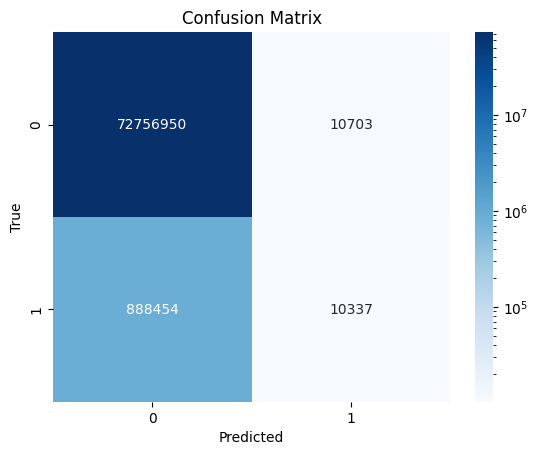

In [14]:
# import lognorm
from matplotlib.colors import LogNorm

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# log scale
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', norm=LogNorm())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
FP = torch.sum((y_true == 0) & (y_pred == 1))
FN = torch.sum((y_true == 1) & (y_pred == 0))
TP = torch.sum((y_true == 1) & (y_pred == 1))
TN = torch.sum((y_true == 0) & (y_pred == 0))

print(f'FP: {FP}, FN: {FN}, TP: {TP}, TN: {TN}')
print(f'Precision: {TP / (TP + FP)}')
print(f'Recall: {TP / (TP + FN)}')
print(f'F1 Score: {2 * TP / (2 * TP + FP + FN)}')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN)}')
print(f'Balanced Accuracy: {0.5 * ((TP / (TP + FN)) + (TN / (TN + FP)))}')

# sensitivity, specificity, precision, recall, f1, accuracy, balanced_accuracy, roc_auc

#  plot table with metrics



FP: 0, FN: 51779, TP: 111072, TN: 0
Precision: 1.0
Recall: 0.6820467710494995
F1 Score: 0.8109724521636963
Accuracy: 0.6820467710494995
Balanced Accuracy: nan


/home/ec2-user/miniconda3/envs/rnalab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,Metric,Value
0,Precision,1.000000
1,Recall,0.682047
2,F1,0.810972
3,Accuracy,0.682047
4,Balanced Accuracy,0.682047


In [ ]:
# FP: 0, FN: 74779, TP: 35432, TN: 0
# Precision: 1.0
# Recall: 0.32149240374565125
# F1 Score: 0.48655959963798523
# Accuracy: 0.32149240374565125
# Balanced Accuracy: nan

In [56]:
#  evaluate the propagation of the missing values
#  by comparing the original data with the propagated data


def evaluate_mask_propagation(original, mask, propagated):
    # tp = torch.logical_and(original == 1, propagated == 1).sum()
    # fp = torch.logical_and(original == 0, propagated == 1).sum()
    # tn = torch.logical_and(original == 0, propagated == 0).sum()
    # fn = torch.logical_and(original == 1, propagated == 0).sum()

    # return tp, fp, tn, fn
    #  evaluate using metrics from sklearn
    y_true = original[mask]
    y_pred = propagated[mask]
    y_pred = y_pred > 0.5

    print(y_true.shape)
    print(y_pred.shape)
    # print(f'Precision score: {precision_score(y_true, y_pred)}')
    # print(f'Recall score: {recall_score(y_true, y_pred)}')
    # print(f'F1 score: {f1_score(y_true, y_pred)}')
    # print(f'Accuracy score: {accuracy_score(y_true, y_pred)}')
    # print(f'Confusion matrix: {confusion_matrix(y_true, y_pred)}')
    # print(f'Classification report: {classification_report(y_true, y_pred)}')
    return 
    

evaluate_mask_propagation(data.x, mask, cloned_data.x)

# tp, fp, tn, fn = evaluate_mask_propagation(data.x, mask, cloned_data.x)
# print(f'True positive: {tp}')
# print(f'False positive: {fp}')
# print(f'True negative: {tn}')
# print(f'False negative: {fn}')
# print(f'Precision: {tp / (tp + fp)}')
# print(f'Recall: {tp / (tp + fn)}')
# print(f'F1-score: {2 * tp / (2 * tp + fp + fn)}')



torch.Size([37209238])
torch.Size([37209238])


In [25]:
# Precision score: 0.1270711370952563
# Recall score: 0.1442619700624525
# F1 score: 0.13512197436918527
# Accuracy score: 0.9774698960510828
# Confusion matrix: [[36305423   449870]
#  [  388458    65487]]
# Classification report: 
# 
#               precision    recall  f1-score   support
#            0       0.99      0.99      0.99  36755293
#            1       0.13      0.14      0.14    453945

#     accuracy                           0.98  37209238
#    macro avg       0.56      0.57      0.56  37209238
# weighted avg       0.98      0.98      0.98  37209238

torch.Size([513176, 145])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
